# Кластеризация. Метод K-Means. Домашнее задание

## Задача

Пусть имеется набор данных `Mall_Customers.csv` о покупателях супермаркета:

* CustomerID — идентификатор покупателя;
* Genre — пол;
* Age — возраст;
* Annual Income (k$) — годовой доход покупателя в тыс. долл.;
* Spending Score (1–100) — рейтинг трат покупателя.

Решите задачу кластеризации покупателей, чтобы в дальнейшем планировать маркетинговые акции для каждой группы.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

### Задание 1

Загрузите датасет и выполните разведочный анализ данных. 

Cделайте выводы о найденных закономерностях, особенностях и других обнаруженных свойствах данных.

In [5]:
# Загрузка данных из файла
df = pd.read_csv("Mall_Customers_(1).csv")

In [6]:
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Описание данных

Дан файл Mall_Customers.csv, содержащий следующие данные по покупателям сети супермаркетов:
- CustomerID — идентификатор покупателя.
- Genre – пол покупателя.
- Age – возраст покупателя.
- Annual Income (k\$) – годовой доход покупателя, тысяч $.
- Spending Score (1–100) – рейтинг покупателя

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Из общей информации df следует:
1. DataFrame содержит 200 записей (от индекса 0 до 199)
2. Всего 5 колонок
3. Нулевые значения отсуствуют
4. Пропущенные значения отсуствуют
5. Колонки CustomerID, Age, Annual Income (k$), Spending Score (1-100) в формате int64 и Genre в формате object

In [8]:
# Статистический анализ числовых переменных
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


На основе представленных статистических данных неприрывных признаков можно сделать следующие выводы:

Age (Возвраст покупателя):

- Средний возвраст на уровне 36.00
- Миниманая 18.00
- Максимальная 70.00
- Медиана равна 39.85
- Отклонение состовляет 13.96

Annual Income (Годовой доход покупателя):

- Средний доход на уровне 61.50
- Миниманая 15.00
- Максимальная 137.00
- Медиана равна 60.56
- Отклонение состовляет 26.26

Spending Score (Рейтинг покупателя):

- Средний рейтинг на уровне 50.00
- Миниманая 99.00
- Максимальная 1.00
- Медиана равна 50.20
- Отклонение состовляет 25.82

CustomerID - уникальный номер клиента не учитываем.

Данные нормализованы, не имеют выбросов.

In [9]:
# Статистический анализ объектных переменных
df.describe(include='object').T

,count,unique,top,freq
Genre,200,2,Female,112



Genre (Пол покупателя):

В данных присутствуют записи о поле у 200 пользователей.
Имеются две уникальные записи о поле покупателя.
Наиболее часто встречающийся запись - Female, с частотой 112 раз.

In [10]:
# Проверка на дубликаты
duplicate_df = df[df.duplicated()]
print("number of duplicate rows: ", duplicate_df.shape)

number of duplicate rows:  (0, 5)


Дубликатов не обнаружено.

In [11]:
# Проверка на NaN значения
df.isnull().any().any()

False

In [12]:
# Проверка на нулевые значения
df.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

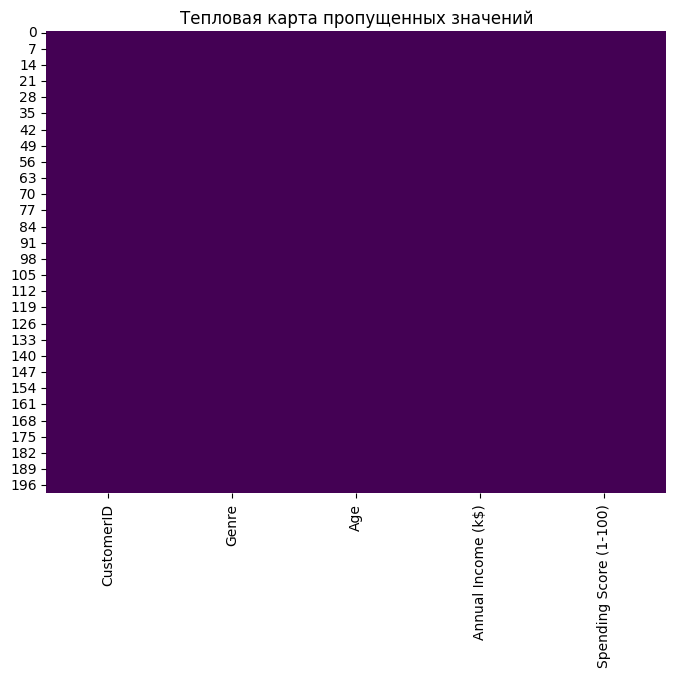

In [13]:
# Визуализация пропущенных значений (тепловая карта)
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Тепловая карта пропущенных значений')
plt.show()

Пропусков/NaN значений не обнаружено. 

##### Исследуем данные по колонкам:

In [14]:
# Удаляем столбец CustomerID 
df = df.drop('CustomerID', axis=1)

Данный столбец CustomerID содержит индивидуальный номер клиента в порядке нумерации от 0 до 199 и не имеет ценности для построения модели или для анализа данных.

In [15]:
# Уникальные значения и их количество Genre
df['Genre'].value_counts()

Genre
Female    112
Male       88
Name: count, dtype: int64

In [16]:
# Уникальные значения и их количество Age
df['Age'].value_counts()

Age
32    11
35     9
19     8
31     8
30     7
49     7
40     6
38     6
47     6
27     6
36     6
23     6
34     5
20     5
29     5
50     5
48     5
21     5
24     4
18     4
28     4
67     4
59     4
54     4
43     3
60     3
45     3
39     3
33     3
37     3
22     3
25     3
46     3
68     3
52     2
44     2
66     2
57     2
26     2
53     2
42     2
63     2
70     2
51     2
58     2
65     2
41     2
55     1
69     1
64     1
56     1
Name: count, dtype: int64

In [17]:
# Уникальные значения и их количество Annual Income (k$)
df['Annual Income (k$)'].value_counts()

Annual Income (k$)
54     12
78     12
48      6
71      6
63      6
       ..
58      2
59      2
16      2
64      2
137     2
Name: count, Length: 64, dtype: int64

In [18]:
# Уникальные значения и их количество Spending Score (1-100)
df['Spending Score (1-100)'].value_counts()

Spending Score (1-100)
42    8
55    7
46    6
73    6
35    5
     ..
31    1
44    1
53    1
65    1
18    1
Name: count, Length: 84, dtype: int64

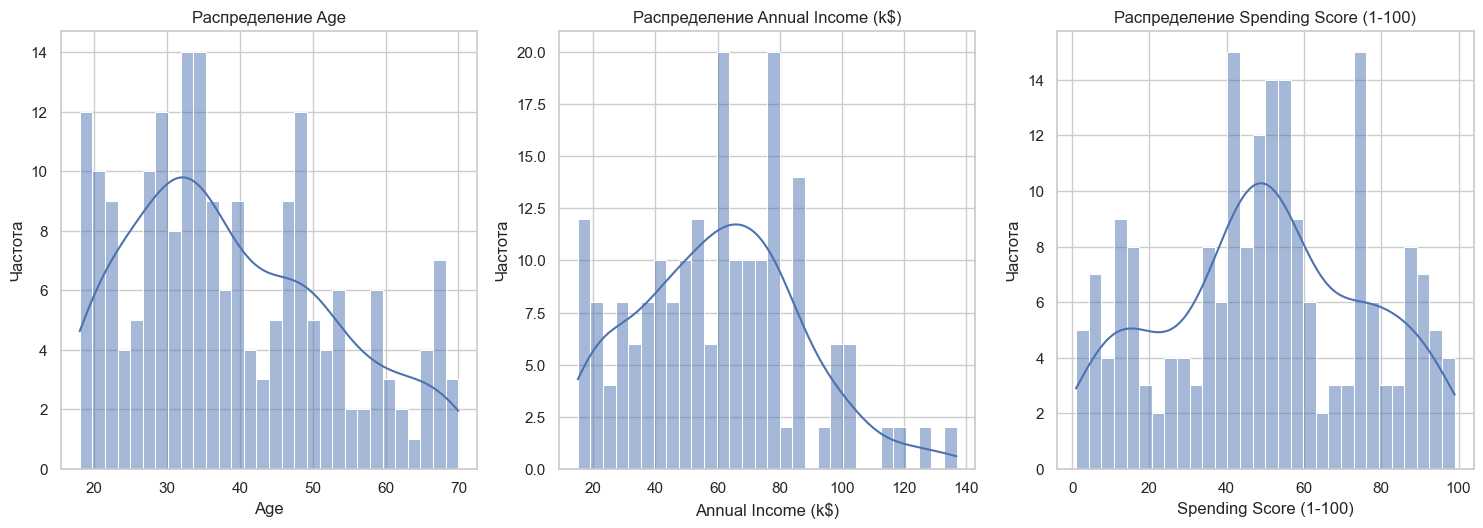

In [19]:
# Установка стиля графиков
sns.set(style="whitegrid")

# Визуализация распределения нескольких выбранных числовых переменных
selected_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

plt.figure(figsize=(15, 10))

for i, column in enumerate(selected_columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f'Распределение {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')

plt.tight_layout()
plt.show()

# !!!Не забыть написать описание графиков!!!

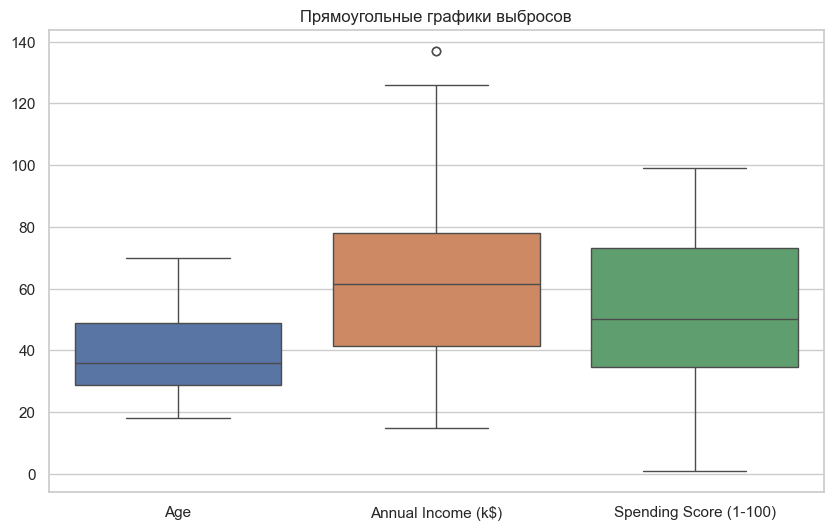

In [20]:
# Прямоугольные графики для визуализации распределений и потенциальных выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']])
plt.title("Прямоугольные графики выбросов")
plt.show()

Замечен небольшой выброс в колонке Annual Income (k$)

C:\Users\Esdesu\AppData\Local\Temp\ipykernel_15512\3025921178.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Genre', data=df, palette='Set2')


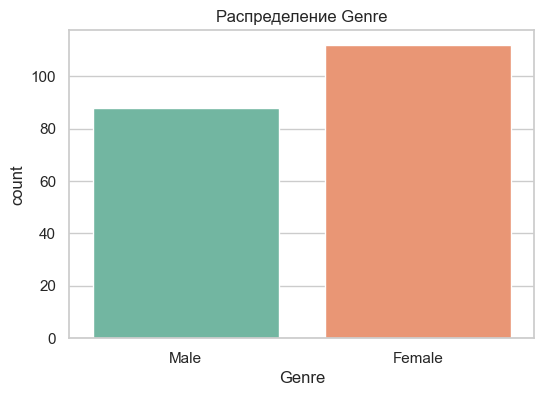

In [22]:
# Проверка баланса категириональных признаков
plt.figure(figsize=(6, 4))
sns.countplot(x='Genre', data=df, palette='Set2')
plt.title("Распределение Genre")
plt.show()

Сильный дисбаланс между классами отсуствует

### Задание 2

Метод k-средних требует явно задать количество кластеров, на которые будут разбиваться данные. Поскольку данных может быть настолько много, что построение одной модели будет занимать несколько часов, важно примерно оценить количество кластеров до запуска обучения модели.

На основе результатов разведочного анализа данных предположите, какое количество кластеров будет оптимальным, и аргументируйте предположение.

### Задание 3

Преобразуйте категориальный признак Genre в численный.

### Задание 4

Постройте модель кластеризации с помощью метода k-средних. Определите оптимальное количество кластеров с помощью метода локтя.

### Задание 5

Постройте финальную модель кластеризации с количеством кластеров, опредёленным в предыдущем задании.

# Кластеризация. DBSCAN

Имеется некоторый набор данных `gt_2015.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды.
* AFDP — перепад давления на воздушном фильтре.
* GTEP — давление на выходе из газовой турбины.
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины.
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа.
* NOX — выбросы оксидов азота.

Решите задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

# Задание 2

Предположите по результатам разведочного анализа данных, какие группы электростанций существуют, чем они отличаются, каково их количество.

# Задание 3

Постройте модель кластеризации DBSCAN. Подберите оптимальные гиперпараметры, руководствуясь как результатами сеточного поиска, так и результатами анализа данных в предыдущих заданиях.

# Задание 4

Интерпретируйте результаты кластеризации: объясните, чем схожи электростанции в каждом кластере и чем аномальные электростанции отличаются от остальных.